author: @SteveEckel

This example covers calculating the forces in a one-dimensional optical molasses
using the optical bloch equations.  It reproduces Fig. 5 of Ungar, P. J., Weiss,
D. S., Riis, E., & Chu, S. (1989). Optical molasses and multilevel atoms:
theory. Journal of the Optical Society of America B, 6(11), 2058.
http://doi.org/10.1364/JOSAB.6.002058

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import pylcp.tools
import time
#plt.style.use('paper')

### Set up the problem

In [4]:
laser_det = 0.
det = -2.73
beta = 1.25

laserBeams = {}
laserBeams['$\\sigma^+\\sigma^+$'] = pylcp.laserBeams([
    {'kvec':np.array([0., 0., 1.]), 'pol':np.array([0., 0., 1.]),
     'pol_coord':'spherical', 'delta':laser_det, 'beta':beta},
    {'kvec':np.array([0., 0., -1.]), 'pol':np.array([0., 0., 1.]),
     'pol_coord':'spherical', 'delta':laser_det, 'beta':beta},
    ], beam_type=pylcp.infinitePlaneWaveBeam)

laserBeams['$\\sigma^+\\sigma^-$'] = pylcp.laserBeams([
    {'kvec':np.array([0., 0., 1.]), 'pol':np.array([0., 0., 1.]),
     'pol_coord':'spherical', 'delta':laser_det, 'beta':beta},
    {'kvec':np.array([0., 0., -1.]), 'pol':np.array([1., 0., 0.]),
     'pol_coord':'spherical', 'delta':laser_det, 'beta':beta},
    ], beam_type=pylcp.infinitePlaneWaveBeam)

phi = [0, np.pi/2]
phi_keys = ['$\phi=0$', '$\phi=\pi/2$']
for phi_i, key_beam in zip(phi, phi_keys):
    laserBeams[key_beam] = pylcp.laserBeams([
        {'kvec':np.array([0., 0., 1.]), 'pol':np.array([1., 0., 0.]),
         'pol_coord':'cartesian', 'delta':0, 'beta':beta},
        {'kvec':np.array([0., 0., -1.]),
         'pol':np.array([np.cos(phi_i), np.sin(phi_i), 0.]),
         'pol_coord':'cartesian', 'delta':0, 'beta':beta}
        ], beam_type=pylcp.infinitePlaneWaveBeam)

# Hamiltonian for F=2->F=3
Hg, Bgq = pylcp.hamiltonians.singleF(F=2, gF=0, muB=1)
He, Beq = pylcp.hamiltonians.singleF(F=3, gF=1/3, muB=1)
dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(2, 3)
hamiltonian = pylcp.hamiltonian(Hg, det*np.eye(7)+He, Bgq, Beq, dijq)

obe_F2_F3 = {}

magField = lambda R: np.zeros(R.shape)

### First, make Fig. 6 from Unager.

Running $\sigma^+\sigma^+$...
Completed in 2:31.                                                  
Total computation time for $\sigma^+\sigma^+$ is 151.420
Running $\sigma^+\sigma^-$...
Completed in 7:40.                                                  
Total computation time for $\sigma^+\sigma^-$ is 460.612
Running $\phi=0$...
Completed in 4:09.                                                  
Total computation time for $\phi=0$ is 249.525
Running $\phi=\pi/2$...
Completed in 4:03.                                                  
Total computation time for $\phi=\pi/2$ is 243.999


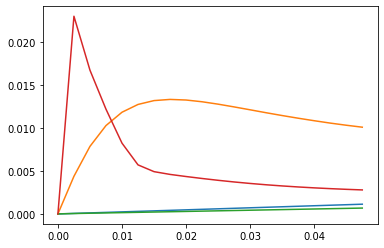

In [5]:
v = np.arange(0.0, 0.05, 0.0025)
keys_of_interest = ['$\\sigma^+\\sigma^+$', '$\\sigma^+\\sigma^-$',
                    '$\phi=0$', '$\phi=\pi/2$']

for key_i in keys_of_interest:
    print('Running %s' % key_i + '...')
    obe_F2_F3[key_i] = pylcp.obe(laserBeams[key_i], magField, hamiltonian,
                                 transform_into_re_im=True)

    tic=time.time()
    obe_F2_F3[key_i].generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_tmax=2*np.pi*1000, deltat_v=4, itermax=1000,
        rel=0.000001, abs=0.0000000001, progress_bar=True
    )
    toc=time.time()
    print('Total computation time for %s is %.3f' % (key_i, toc-tic))

fig, ax = plt.subplots(1, 1, num="Forces; F=2 to F=3")
for key_i in keys_of_interest:
    ax.plot(v, obe_F2_F3[key_i].profile['molasses'].F[2], label=key_i)

### Now, make Fig. 8 from Unager.

In [ ]:
dets = [-1.0, -1.37, -2.73]
betas = [0.5, 1.25, 2.5]

key_i = '$\\sigma^+\\sigma^-$'

fig, ax = plt.subplots(2, 1, num="Forces vs. detuning and intensity",
                        figsize=(3.25, 2*2.75))

for det in dets:
    for beam in laserBeams[key_i].beam_vector:
        beam.delta = det

    obe = pylcp.obe(laserBeams[key_i], magField, hamiltonian)

    obe.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_tmax=2*np.pi*1000, deltat_v=4, itermax=1000#,
        rel=1e-6, abs=1e-10, progress_bar=True
    )

    ax[0].plot(v, obe.profile['molasses'].F[2], label='$\delta = %f' % det)

for beta in betas:
    for beam in laserBeams[key_i].beam_vector:
        beam.beta = beta

    obe = pylcp.obe(laserBeams[key_i], magField, hamiltonian)

    obe.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_tmax=2*np.pi*1000, deltat_v=4, itermax=1000,
        rel=1e-6, abs=1e-10, progress_bar=True
    )

    ax[1].plot(v, obe.profile['molasses'].F[2], label='$\beta = %f' % beta)

# Reset the key back to the default value:
for beams in laserBeams[key_i].beam_vector:
    beam.beta = 1.25

### Now, make Fig. 9 from Unager.

Completed in 1:22.                                                  


TypeError: 'float' object is not callable

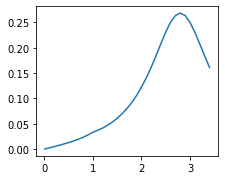

In [7]:
keys_of_interest = ['$\\sigma^+\\sigma^+$', '$\\sigma^+\\sigma^-$']

v = np.concatenate((np.arange(0.01, 0.2, 0.01), np.arange(0.2, 3.5, 0.1)))

fig, ax = plt.subplots(1, 1, num="Force to Doppler velocity",
                       figsize=(3.25, 2.75))

for key in keys_of_interest:
    obe = pylcp.obe(laserBeams[key], magField, hamiltonian)

    obe.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_tmax=2*np.pi*1000, deltat_v=4, itermax=1000,
        rel=1e-6, abs=1e-10, progress_bar=True
    )

    ax.plot(v, obe.profile['molasses'].F[2], label=key)